In [21]:
#CNN dipakai image detection, audio, dan text juga bisa karena bisa memproses 3D  banyak layer
#Gambar terdiri dari channel yaitu warna terdiri dari Grayscale ada 1 channel dan RGB ada 3 channel
#CNN ada tahap feature extraction terdiri 3 layer yaitu Convolutional, Max Poolingm dan Fully Connected Layer (FCC)
#Convolutional fungsinya membaca objek dari setiap pixel untuk mengenali pola pixel
#Max Pooling fungsinya mencari nilai optimal dari array yang terbentuk dari hasil komputasi (hasil matriks perhitungan pola pixel dikali kernel)
#Fully Connected Layer itu proses penggabungan perhitungan matriks dengan neuron

#Stride itu pergeseran matriks fungsinya model mampu melihat pola pixel
#Down Sample : matriks paling besar diubah matriksnya semakin kecil (Filternya)
#Auto Encoder : gabungan encoder(downsample) dengan deccoder (up)

#Model Deep Learning ada VGG, Resnet, Alexnet

In [22]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split

In [23]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

batch_size = 128
nb_classes = 10
img_rows, img_cols = 28, 28

In [24]:
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [25]:
X = np.concatenate([X, X_test], axis=0)
y = np.concatenate([y, y_test], axis=0)

In [26]:
#Resnet (residual network) ada 2 konvolusi terjadi skip connection

In [27]:
################################################################################
# TODO:                                                                        #
# Split the data into training, validation, and testing sets.                  #
# First, split the data into 80% training and 20% temporary data (for          #
# validation and testing). Then, split the temporary data equally into         #
# validation and test sets (10% each).                                         #
################################################################################

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [28]:
################################################################################
# TODO:                                                                        #
# Reshape the training, validation, and test data to match the input shape     #
# required by the model (28x28 pixels with 1 channel for grayscale images).    #
# Normalize the pixel values by dividing by 255 to scale them between 0 and 1. #
# Finally, print the shape of the reshaped datasets and the number of samples  #
# in the training and test sets.                                               #
################################################################################

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1).astype("float32") / 255
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows, 1).astype("float32") / 255
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1).astype("float32") / 255

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(56000, 28, 28, 1)
(7000, 28, 28, 1)
(7000, 28, 28, 1)


In [29]:
################################################################################
# TODO:                                                                        #
# Convert the digit labels (0-9) into one-hot encoded binary vectors using     #
# the `to_categorical` function. This is necessary for the multi-class         #
# classification task, where the labels need to be in binary format.           #
# Additionally, visualize the first 9 images from the training set using       #
# matplotlib to display the images in grayscale.                               #
################################################################################

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)

print(y_train[1])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
################################################################################
# TODO:                                                                        #
# Define a residual block for the neural network. This block consists of two   #
# convolutional layers followed by batch normalization and ReLU activations.   #
# If downsampling is needed, adjust the stride to reduce the spatial size of   #
# the input and use a 1x1 convolution on the shortcut connection to match the  #
# dimensions. Finally, the output of the block adds the shortcut connection to #
# the result of the convolutions (skip connection), followed by a ReLU         #
# activation.                                                                  #
################################################################################
def residual_block(X, filter, downsample=False):
    X_shortcut = X
    
    if downsample:
        stride = 2
        X_shortcut = Conv2D(filter, kernel_size=(1,1), strides=stride, padding="valid")(X_shortcut) #best pratice 2 pangkat n
        X_shortcut = BatchNormalization()(X_shortcut)
    else:
        stride = 1
    
    #Layer Pertama    
    X = Conv2D(filter, kernel_size=(3, 3), strides=stride, padding="same")(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    #Layer Kedua
    X = Conv2D(filter, kernel_size=(3, 3), strides=stride, padding="same")(X)
    X = BatchNormalization()(X)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [31]:
################################################################################
# TODO:                                                                        #
# Define the ResNet18 architecture using residual blocks. Start with an        #
# initial convolutional layer followed by batch normalization, ReLU activation,#
# and max pooling. Then, build the network using a series of residual blocks,  #
# with downsampling when needed, for progressively increasing feature sizes.   #
# Finally, use a global average pooling layer before the output dense layer,   #
# which classifies the input into the specified number of classes              #
# using softmax. The output should be a Keras model.                           #
################################################################################
def Resnet18_model(input_shape, number_classes):
    X_input = Input(input_shape)
    #Inisialisasi lyaer coinvolutional 1
    X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding="same")(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(3,3))(X)
    
    #Residual Block (Conv Block + Identity Block)
    X = residual_block(X, 64)
    X = residual_block(X, 64)
    
    X = residual_block(X, 128, downsample=True)
    X = residual_block(X, 128)
    
    X = residual_block(X, 256, downsample=True)
    X = residual_block(X, 256)
    
    X = residual_block(X, 512, downsample=True)
    X = residual_block(X, 512)
    
    X = GlobalAveragePooling2D()(X)
    
    #Fully Connected Layer
    X = Dense(number_classes, activation='softmax')(X)
    #Compile jadi 1 model yang utuh
    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    return model


In [32]:
################################################################################
# TODO:                                                                        #
# Build and compile the ResNet18 model using the input shape and number of     #
# classes. Use the Adam optimizer and categorical crossentropy as the loss     #
# function since this is a multi-class classification problem. Set accuracy as #
# a metric to monitor the model's performance.                                 #
################################################################################

model = Resnet18_model(input_shape=(img_cols, img_rows, 1), number_classes=nb_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 14, 14, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 14, 14, 64)   0           ['batch_normalization_20[0]

In [34]:
################################################################################
# TODO:                                                                        #
# Train the ResNet18 model using the training data and evaluate its            #
# performance on the validation set. The model will train for a specified      #
# number of epochs, and after training, the test accuracy and loss will be     #
# evaluated. Additionally, make predictions on the test set and convert        #
# the results from one-hot encoding to label encoding for further analysis.    #
################################################################################
n_epoch = 20
hist = model.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size, validation_data=((X_val, y_val)))

Epoch 1/20
438/438 [==============================] - 723s 2s/step - loss: 0.1821 - accuracy: 0.9486 - val_loss: 0.4964 - val_accuracy: 0.8304
Epoch 2/20
438/438 [==============================] - 728s 2s/step - loss: 0.0676 - accuracy: 0.9798 - val_loss: 0.0598 - val_accuracy: 0.9831
Epoch 3/20
438/438 [==============================] - 733s 2s/step - loss: 0.0527 - accuracy: 0.9842 - val_loss: 0.0479 - val_accuracy: 0.9861
Epoch 4/20
438/438 [==============================] - 720s 2s/step - loss: 0.0421 - accuracy: 0.9873 - val_loss: 0.0678 - val_accuracy: 0.9817
Epoch 5/20
438/438 [==============================] - 729s 2s/step - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0755 - val_accuracy: 0.9789
Epoch 6/20
438/438 [==============================] - 722s 2s/step - loss: 0.0336 - accuracy: 0.9899 - val_loss: 0.0568 - val_accuracy: 0.9839
Epoch 7/20
438/438 [==============================] - 1559s 4s/step - loss: 0.0281 - accuracy: 0.9915 - val_loss: 0.0563 - val_accuracy: 0.983

In [35]:
################################################################################
# TODO:                                                                        #
# Evaluate the model's performance using the test set. Print out the test loss #
# and accuracy. The model is evaluated based on the categorical crossentropy   #
# loss and accuracy metrics defined earlier during compilation.                #
################################################################################
score = model.evaluate(X_test, y_test)
print(score)

219/219 [==============================] - 4s 18ms/step - loss: 0.0568 - accuracy: 0.9856
[0.05683093145489693, 0.9855714440345764]


In [36]:
################################################################################
# TODO:                                                                        #
# Make predictions using the trained model on the test data. Convert the       #
# predictions from one-hot encoded format back to label format using           #
# `np.argmax`. This will give the predicted label for each test sample.        #
################################################################################
pred = model.predict(X_test)
predicted_label = np.argmax(pred, axis=1)

219/219 [==============================] - 4s 18ms/step


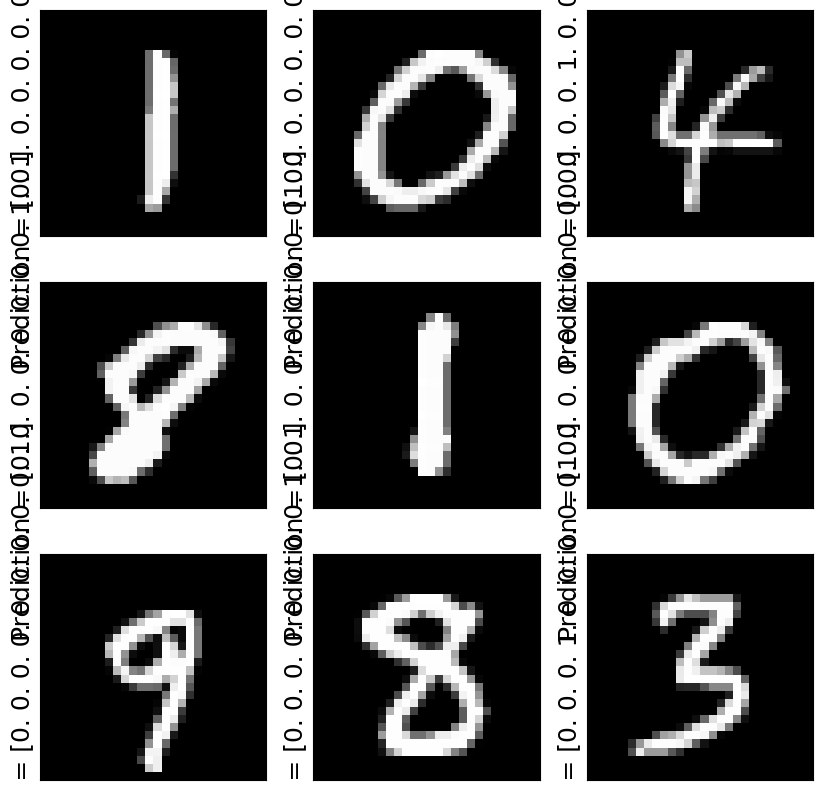

In [37]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel("Prediction = {}".format(y_test[i]), fontsize=18)

plt.savefig("Predictions.png")
plt.show()

Test loss 0.0568, accuracy 98.56%


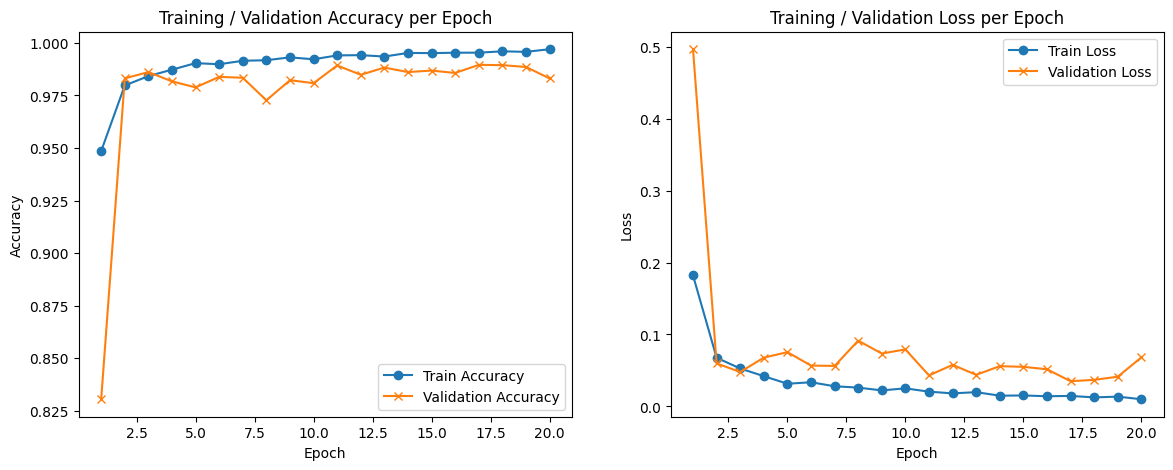

In [38]:
# Evaluate the model on the test set
test_score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

# Create subplots for accuracy and loss side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation accuracy on the first subplot
ax1.plot([None] + hist.history["accuracy"], "o-")
ax1.plot([None] + hist.history["val_accuracy"], "x-")
ax1.legend(["Train Accuracy", "Validation Accuracy"], loc=0)
ax1.set_title("Training / Validation Accuracy per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

# Plot training and validation loss on the second subplot
ax2.plot([None] + hist.history["loss"], "o-")
ax2.plot([None] + hist.history["val_loss"], "x-")
ax2.legend(["Train Loss", "Validation Loss"], loc=0)
ax2.set_title("Training / Validation Loss per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

# Save the plots and show
plt.savefig("Training and Validation Accuracy and Loss per Epoch.png")
plt.show()